In [1]:
%%HTML
<style>
p {
    color: #343a40;
}

h1 a.anchor-link {
    color: #F7ECCB;
}

h1 {
    background-color: #343a40;
    width: fit-content;
    padding: 15px;
    color: white;
    text-align: center;
    width: 100%;
}

.intro {
    width: 60%;
    margin: auto;
    text-align: justify !important;
    font-family: Georgia;
}

.output_png {
    display: flex;
    align-items: center;
    justify-content: center;
}

.hide_btn {
    background-color: #343a40;
    padding: 15px;
    color: white;
    border-radius: 30px;
    border: none;
}
</style>

In [2]:
%%HTML
<script>
    code_show=true;
    function code_toggle() {
         if (code_show){
             $('div.input').hide();
         } else {
             $('div.input').show();
         }
         code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
    <input class='hide_btn' type="submit"
    value="Toggle code">
</form>

In [3]:
import os
os.environ['SKIMAGE_DATADIR'] = '/tmp/.skimage_cache'

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [9]:
from skimage.io import imread, imshow
from skimage.transform import downscale_local_mean
from skimage.color import rgb2gray, rgb2hsv, gray2rgb
from skimage import img_as_ubyte, img_as_float
from skimage.exposure import histogram, cumulative_distribution
from skimage.morphology import closing, opening, area_closing, area_opening, erosion, dilation
from skimage.measure import label, regionprops

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.stats import norm
from scipy.signal import convolve2d

# Chapter 6: You in the Red Shirt (Part 2)

<p class='intro'><br>Dear diary,<br>
I was tossing and turning all last night. I had seem him at the party, and I couldn't get the image of him flirting with those other girls out of my head. I need to think. I need some space to think.
</p>
<p class='intro'><i>He's making me crazy.</i></p>

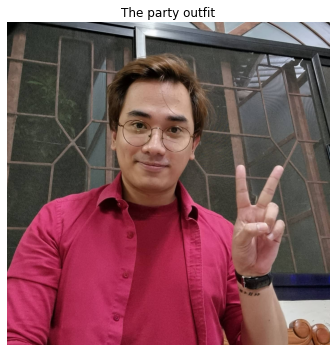

In [7]:
ch6 = imread('images/ch5-6.jpg')
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('The party outfit')
plt.tight_layout()
plt.imshow(ch6);

Him and his cute smile at that party yesterday, and him sharing it with everyone. I do not approve. I'll try this segmentation thing again. Maybe that'll keep my mind off of what happened yesterday. Maybe I can use the RG chromaticity of this dang shirt.

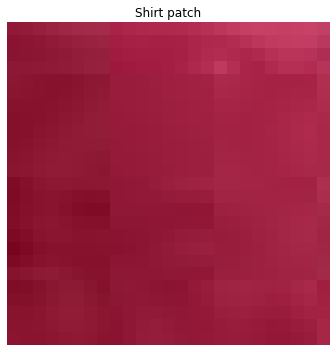

In [10]:
shirt_patch = ch6[1100:1125,200:225]
plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Shirt patch')
plt.tight_layout()
plt.imshow(shirt_patch);

With the patch, the red and green probabilities can be calculated, and the probability of the blue extrapolated.

In [11]:
def gaussian(p,mean,std):
    return np.exp(-(p-mean)**2/(2*std**2))*(1/(std*((2*np.pi)**0.5)))

def get_rg_prob(img, patch_loc):
    img_R = img[:,:,0]*1.0/img.sum(axis=2)
    img_G = img[:,:,1]*1.0/img.sum(axis=2)
    
    x, y = patch_loc
    patch = img[y:y+25,x:x+25,:]
    patch_R = patch[:,:,0]*1.0/patch.sum(axis=2)
    patch_G = patch[:,:,1]*1.0/patch.sum(axis=2)
    
    std_patch_R = np.std(patch_R.flatten())
    mean_patch_R = np.mean(patch_R.flatten())

    std_patch_G = np.std(patch_G.flatten())
    mean_patch_G = np.mean(patch_G.flatten())
    
    r_test = np.tile(np.linspace(0,1,64),(64,1))
    g_test = r_test.transpose()
    
    test_R = gaussian(r_test,mean_patch_R,std_patch_R)
    test_G = gaussian(g_test,mean_patch_G,std_patch_G)
    
    prob_test=test_R * test_G
    
    prob_R = gaussian(img_R,mean_patch_R,std_patch_R)
    prob_G = gaussian(img_G,mean_patch_G,std_patch_G)
    
    prob=prob_R * prob_G
    
    return prob

Adding together the likelihood that the type of green and the type of red you want is in a certain pixel, you get the mask for what you're looking for.

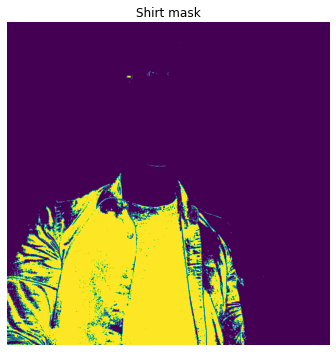

In [12]:
shirt_chrom = get_rg_prob(ch6, (200,1100))
shirt_mask = shirt_chrom > 1.2

plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Shirt mask')
plt.tight_layout()
plt.imshow(shirt_mask);

I tried the short mask again, with some of the creases still missing, but better than when I used the RGB color space for segmentation.

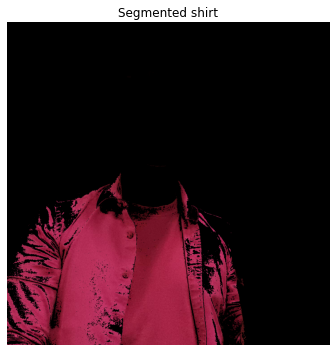

In [14]:
def apply_mask(image, filt):
    ch1 = image[:,:,0]*filt
    ch2 = image[:,:,1]*filt
    ch3 = image[:,:,2]*filt
    image_masked = np.dstack((ch1, ch2, ch3))
    return image_masked


plt.figure(figsize=(20, 5))
plt.axis('off')
plt.title('Segmented shirt')
plt.tight_layout()
plt.imshow(apply_mask(ch6, shirt_mask));

<p class='intro'>Well, I think I was able to calm my mind with that a bit. But I should be making my next steps to insert myself into his life.</p>
<p class='intro'><i>I'm going to be his future. xoxo</i></p>